# Thinking

### 1：如何使用用户标签来指导业务（如何提升业务）

推荐系统的目的是联系用户的兴趣和物品，这种联系需要依赖于不同的媒介。标签是一种无层次化结构的、用来描述信息的关键词。因此，标签可以用来准确地描述物品的语义。通过引入用户标签可以极大程度程度上提升对用户进行更好的偏好分析，完成个性化推荐服务。在用户生命周期的三个阶段：获客阶段：进行拉新，通过更精准的营销获取客户；粘客阶段：个性化推荐，搜索排序，场景运营等；留客阶段：流失率预测，分析关键节点降低流失率，都需要通过用户标签分析作为辅助。

### 2：如果给你一堆用户数据，没有打标签。你该如何处理（如何打标签）

标签的获取有两种典型手段：即PGG专家生产和UGC。
PCG是通过作者或者专家为物品打上标签，UGC是依靠普通用户为商品打上标签。


标签是对高维事物的抽象，获取标签还可以通过一些聚类算法如K-Means，EM聚类，Mean-Shift，DBSCAN，层次聚类等

### 3：准确率和精确率有何不同

准确率：

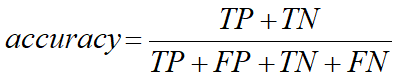

精确率：

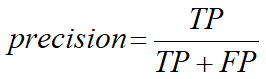

由二者计算公式可以明显看出：精确率只关心正例中预测正确的情况，而准确率不仅考虑了正例中的正确预测比例还考量了反例中的正确预测，对一些受类别分布不平衡影响的数据可以在整体上更好反映预测性能情况。

### 4：如果你使用大众点评，想要给某个餐厅打标签。这时系统可以自动提示一些标签，你会如何设计（标签推荐）

当用户给物品打标签时，可以给用户推荐和物品相关的标签，针对此问题方法如下：


方法1：给用户u推荐整个餐饮相关的最热门的标签
方法2：给用户u推荐本间餐厅最热门的标签
方法3：给用户u推荐他自己经常使用的标签
将方法2和3进行加权融合，生成最终的标签推荐结果

### 5：我们今天使用了10种方式来解MNIST，这些方法有何不同？你还有其他方法来解决MNIST识别问题么（分类方法）

如Logistic Regression、CART，ID3（决策树）、LDA、SVM等属于利用传统机器学习分类算法处理MNIST数字图像转化的梳子矩阵数据，完成多分类问题。

Adaboost、XGBoost是基于boosting原理引入弱分类器的集成（根据模型效果赋予不同弱分类器权重）提升模型训练效果。

TPOT是基于python的自动机器学习框架，可以解决：特征选择，模型选择，但不包括数据清洗，完成最优模型的选择。

LeNet-5网络是基于cnn的深度神经网络模型，引入卷积核的方法扫描图像的数字二维矩阵，再通过多层神经网络进行训练拟合。

除了上述方法还可以直接使用多层感知器进行训练得到分类结果。

# Action

### 1：针对Delicious数据集，对SimpleTagBased算法进行改进（使用NormTagBased、TagBased-TFIDF算法）

In [1]:
import random

import math

import operator

### NormTagBased

In [3]:
class NormTagBased():
    # 构造函数
    def __init__(self,filename):
        self.filename=filename
        self.loadData()
        self.randomlySplitData(0.2)
        self.initStat()
        self.testRecommend()

        
    # 数据加载
    def loadData(self):
        print("开始数据加载...")
        filename=self.filename
        # 保存了用户对item的tag
        self.records={}
        fi=open(filename)
        lineNum=0
        for line in fi:
            lineNum+=1
            if lineNum==1:
                continue
            uid,iid,tag,timestamp=line.split('\t')
            # 在数组中对应的下标-1
            uid=int(uid)-1
            iid=int(iid)-1
            tag=int(tag)-1
            self.records.setdefault(uid,{})
            self.records[uid].setdefault(iid,[])
            self.records[uid][iid].append(tag)
        fi.close()
        print("数据集大小为 %d." % (lineNum))
        print("设置tag的人数 %d." % (len(self.records)))
        print("数据加载完成\n")
    
    # 将数据集拆分为训练集和测试集
    def randomlySplitData(self,ratio,seed=100):
        random.seed(seed)
        self.train=dict()
        self.test=dict()
        for u in self.records.keys():
            for i in self.records[u].keys():
                if random.random()<ratio:
                    self.test.setdefault(u,{})
                    self.test[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.test[u][i].append(t)
                else:
                    self.train.setdefault(u,{})
                    self.train[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.train[u][i].append(t)        
        print("训练集样本数 %d, 测试集样本数 %d" % (len(self.train),len(self.test)))
    
    # 使用训练集，初始化user_tags, tag_items, user_items
    def initStat(self):
        records=self.train
        self.user_tags=dict()
        self.tag_items=dict()
        self.user_items=dict()
        self.tag_users=dict()
        for u,items in records.items():
            for i,tags in items.items():
                for tag in tags:
                    #print tag
                    # 用户和tag的关系
                    self._addValueToMat(self.user_tags,u,tag,1)
                    # tag和item的关系
                    self._addValueToMat(self.tag_items,tag,i,1)
                    # 用户和item的关系
                    self._addValueToMat(self.user_items,u,i,1)
                    # 算法改进：增添tag和用户的关系的储蓄表 用于后续计算打分时更改公式 
                    self._addValueToMat(self.tag_users,tag,u,1)
        print("user_tags, tag_items, user_items初始化完成.")
        print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d，tag_users大小 %d" % (len(self.user_tags),len(self.tag_items),len(self.user_items),len(self.tag_users)))
    
    # 设置矩阵 mat[index, item] = 1
    def _addValueToMat(self,mat,index,item,value=1):
        if index not in mat:
            mat.setdefault(index,{})
            mat[index].setdefault(item,value)
        else:
            if item not in mat[index]:
                mat[index][item] = value
            else:
                mat[index][item] += value
    # 使用测试集，计算准确率和召回率

    def precisionAndRecall(self, N):
        hit=0
        h_recall=0
        h_precision=0
        for user,items in self.test.items():
            if user not in self.train:
                continue
            # 获取Top-N推荐列表
            rank=self.recommend(user,N)
            for item,rui in rank:
                if item in items:
                    hit+=1
            h_recall+=len(items)
            h_precision+=N
        #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
        # 返回准确率 和 召回率
        return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))
    
    # 对用户user推荐Top-N
    def recommend(self,user,N):
        recommend_items=dict()
        # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
        tagged_items = self.user_items[user]  
        for tag, wut in self.user_tags[user].items():
            #print(self.user_tags[user].items())
            for item, wti in self.tag_items[tag].items():
                if item in tagged_items:
                    continue
                #print('wut = %s, wti = %s' %(wut, wti))
                if item not in recommend_items:
                    recommend_items[item] = (wut/len(self.user_tags[user])) * (wti/len(self.tag_users[tag]))#改进
                else:
                    recommend_items[item] += (wut/len(self.user_tags[user])) * (wti/len(self.tag_users[tag]))#改进
        return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]
    
    # 使用测试集，对推荐结果进行评估
    def testRecommend(self):
        print("推荐结果评估")
        print("%3s %10s %10s" % ('N',"精确率",'召回率'))
        for n in [5,10,20,40,60,80,100]:
            precision,recall=self.precisionAndRecall(n)
            print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
            
if __name__=='__main__':

    stb=NormTagBased("D://python//看课吧推荐系统//data and code//l2//l2data//user_taggedbookmarks-timestamps.dat")

开始数据加载...
数据集大小为 437594.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860，tag_users大小 36884
推荐结果评估
  N        精确率        召回率
  5      0.907%      0.388%
 10      0.638%      0.546%
 20      0.507%      0.868%
 40      0.356%      1.218%
 60      0.287%      1.476%
 80      0.255%      1.750%
100      0.241%      2.061%


相比simpletagbased，normtafbased在对item打分时将socre计算公式进行了归一化，除以分母即len(user_tags[user])和len(tag_users[tag])的乘积。

如果len（user_tags[u]）很大的话，即改用户打过标签的次数很多，因此这个tag对这个用户而言并不能很好反应他对商品的兴趣，同理len（tag_users[t]）很大表明该tag被很多用户打过，并不能专属于这个user，无法体现个性化兴趣。

### TagBasedTFIDF（对热门标签进行惩罚）

In [5]:
class TagBased_Tfidf():
    # 构造函数
    def __init__(self,filename):
        self.filename=filename
        self.loadData()
        self.randomlySplitData(0.2)
        self.initStat()
        self.testRecommend()

        
    # 数据加载
    def loadData(self):
        print("开始数据加载...")
        filename=self.filename
        # 保存了用户对item的tag
        self.records={}
        fi=open(filename)
        lineNum=0
        for line in fi:
            lineNum+=1
            if lineNum==1:
                continue
            uid,iid,tag,timestamp=line.split('\t')
            # 在数组中对应的下标-1
            uid=int(uid)-1
            iid=int(iid)-1
            tag=int(tag)-1
            self.records.setdefault(uid,{})
            self.records[uid].setdefault(iid,[])
            self.records[uid][iid].append(tag)
        fi.close()
        print("数据集大小为 %d." % (lineNum))
        print("设置tag的人数 %d." % (len(self.records)))
        print("数据加载完成\n")
    
    # 将数据集拆分为训练集和测试集
    def randomlySplitData(self,ratio,seed=100):
        random.seed(seed)
        self.train=dict()
        self.test=dict()
        for u in self.records.keys():
            for i in self.records[u].keys():
                if random.random()<ratio:
                    self.test.setdefault(u,{})
                    self.test[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.test[u][i].append(t)
                else:
                    self.train.setdefault(u,{})
                    self.train[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.train[u][i].append(t)        
        print("训练集样本数 %d, 测试集样本数 %d" % (len(self.train),len(self.test)))
    
    # 使用训练集，初始化user_tags, tag_items, user_items
    def initStat(self):
        records=self.train
        self.user_tags=dict()
        self.tag_items=dict()
        self.user_items=dict()
        self.tag_users=dict()
        for u,items in records.items():
            for i,tags in items.items():
                for tag in tags:
                    #print tag
                    # 用户和tag的关系
                    self._addValueToMat(self.user_tags,u,tag,1)
                    # tag和item的关系
                    self._addValueToMat(self.tag_items,tag,i,1)
                    # 用户和item的关系
                    self._addValueToMat(self.user_items,u,i,1)
                    # 算法改进：增添tag和用户的关系的储蓄表 用于后续计算打分时更改公式 
                    self._addValueToMat(self.tag_users,tag,u,1)
        print("user_tags, tag_items, user_items初始化完成.")
        print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d，tag_users大小 %d" % (len(self.user_tags),len(self.tag_items),len(self.user_items),len(self.tag_users)))
    
    # 设置矩阵 mat[index, item] = 1
    def _addValueToMat(self,mat,index,item,value=1):
        if index not in mat:
            mat.setdefault(index,{})
            mat[index].setdefault(item,value)
        else:
            if item not in mat[index]:
                mat[index][item] = value
            else:
                mat[index][item] += value
    # 使用测试集，计算准确率和召回率

    def precisionAndRecall(self, N):
        hit=0
        h_recall=0
        h_precision=0
        for user,items in self.test.items():
            if user not in self.train:
                continue
            # 获取Top-N推荐列表
            rank=self.recommend(user,N)
            for item,rui in rank:
                if item in items:
                    hit+=1
            h_recall+=len(items)
            h_precision+=N
        #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
        # 返回准确率 和 召回率
        return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))
    
    # 对用户user推荐Top-N
    def recommend(self,user,N):
        recommend_items=dict()
        # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
        tagged_items = self.user_items[user]  
        for tag, wut in self.user_tags[user].items():
            #print(self.user_tags[user].items())
            for item, wti in self.tag_items[tag].items():
                if item in tagged_items:
                    continue
                #print('wut = %s, wti = %s' %(wut, wti))
                if item not in recommend_items:
                    recommend_items[item] = (wut/math.log(1+len(self.tag_users[tag])))* wti#改进
                else:
                    recommend_items[item] += (wut/math.log(1+len(self.tag_users[tag])))* wti#改进
        return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]
    
    # 使用测试集，对推荐结果进行评估
    def testRecommend(self):
        print("推荐结果评估")
        print("%3s %10s %10s" % ('N',"精确率",'召回率'))
        for n in [5,10,20,40,60,80,100]:
            precision,recall=self.precisionAndRecall(n)
            print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
            
if __name__=='__main__':

    stb=TagBased_Tfidf("D://python//看课吧推荐系统//data and code//l2//l2data//user_taggedbookmarks-timestamps.dat")

开始数据加载...
数据集大小为 437594.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860，tag_users大小 36884
推荐结果评估
  N        精确率        召回率
  5      1.008%      0.431%
 10      0.761%      0.652%
 20      0.549%      0.940%
 40      0.402%      1.376%
 60      0.328%      1.687%
 80      0.297%      2.033%
100      0.269%      2.306%


如果一个tag很热门，会导致user_tags[t]很大，所以即使tag_items[u,t]很小，也会导致score(u,i)很大。给热门标签过大的权重，不能反应用户个性化的兴趣。

倾向于给热门标签和热门物品很大的权重，可以利用TF-IDF，对公式进行改进¶

借鉴TF-IDF的思想，使用tag_users[t]表示标签t被多少个不同的用户使用

同时考量对热门物品和热门标签进行惩罚，则可以使用agBasedTFIDF++ 改进效果：适当惩罚热门标签和热门物品，在增进推荐结果个性化的同时并不会降低推荐结果的离线精度


# TagBasedTFIDF++（对热门物品和热门标签进行惩罚）

In [2]:
class TagBasedTFIDF_():
    # 构造函数
    def __init__(self,filename):
        self.filename=filename
        self.loadData()
        self.randomlySplitData(0.2)
        self.initStat()
        self.testRecommend()

        
    # 数据加载
    def loadData(self):
        print("开始数据加载...")
        filename=self.filename
        # 保存了用户对item的tag
        self.records={}
        fi=open(filename)
        lineNum=0
        for line in fi:
            lineNum+=1
            if lineNum==1:
                continue
            uid,iid,tag,timestamp=line.split('\t')
            # 在数组中对应的下标-1
            uid=int(uid)-1
            iid=int(iid)-1
            tag=int(tag)-1
            self.records.setdefault(uid,{})
            self.records[uid].setdefault(iid,[])
            self.records[uid][iid].append(tag)
        fi.close()
        print("数据集大小为 %d." % (lineNum))
        print("设置tag的人数 %d." % (len(self.records)))
        print("数据加载完成\n")
    
    # 将数据集拆分为训练集和测试集
    def randomlySplitData(self,ratio,seed=100):
        random.seed(seed)
        self.train=dict()
        self.test=dict()
        for u in self.records.keys():
            for i in self.records[u].keys():
                if random.random()<ratio:
                    self.test.setdefault(u,{})
                    self.test[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.test[u][i].append(t)
                else:
                    self.train.setdefault(u,{})
                    self.train[u].setdefault(i,[])
                    for t in self.records[u][i]:
                        self.train[u][i].append(t)        
        print("训练集样本数 %d, 测试集样本数 %d" % (len(self.train),len(self.test)))
    
    # 使用训练集，初始化user_tags, tag_items, user_items
    def initStat(self):
        records=self.train
        self.user_tags=dict()
        self.tag_items=dict()
        self.user_items=dict()
        self.tag_users=dict()
        self.item_users=dict()
        for u,items in records.items():
            for i,tags in items.items():
                for tag in tags:
                    #print tag
                    # 用户和tag的关系
                    self._addValueToMat(self.user_tags,u,tag,1)
                    # tag和item的关系
                    self._addValueToMat(self.tag_items,tag,i,1)
                    # 用户和item的关系
                    self._addValueToMat(self.user_items,u,i,1)
                    # 算法改进：增添tag和用户的关系的储蓄表 用于后续计算打分时更改公式 
                    self._addValueToMat(self.tag_users,tag,u,1)
                    # 算法改进：增添item和用户的关系的储蓄表 用于后续计算打分时更改公式 
                    self._addValueToMat(self.item_users,i,u,1)
        print("user_tags, tag_items, user_items初始化完成.")
        print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d，tag_users大小 %d" % (len(self.user_tags),len(self.tag_items),len(self.user_items),len(self.tag_users)))
    
    # 设置矩阵 mat[index, item] = 1
    def _addValueToMat(self,mat,index,item,value=1):
        if index not in mat:
            mat.setdefault(index,{})
            mat[index].setdefault(item,value)
        else:
            if item not in mat[index]:
                mat[index][item] = value
            else:
                mat[index][item] += value
    # 使用测试集，计算准确率和召回率

    def precisionAndRecall(self, N):
        hit=0
        h_recall=0
        h_precision=0
        for user,items in self.test.items():
            if user not in self.train:
                continue
            # 获取Top-N推荐列表
            rank=self.recommend(user,N)
            for item,rui in rank:
                if item in items:
                    hit+=1
            h_recall+=len(items)
            h_precision+=N
        #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
        # 返回准确率 和 召回率
        return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))
    
    # 对用户user推荐Top-N
    def recommend(self,user,N):
        recommend_items=dict()
        # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
        tagged_items = self.user_items[user]  
        for tag, wut in self.user_tags[user].items():
            #print(self.user_tags[user].items())
            for item, wti in self.tag_items[tag].items():
                if item in tagged_items:
                    continue
                #print('wut = %s, wti = %s' %(wut, wti))
                if item not in recommend_items:
                    recommend_items[item] = (wut/math.log(1+len(self.tag_users[tag])))* (wti/math.log(1+len(self.tag_users[tag])))#改进
                else:
                    recommend_items[item] += (wut/math.log(1+len(self.tag_users[tag])))* (wti/math.log(1+len(self.tag_users[tag])))#改进
        return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]
    
    # 使用测试集，对推荐结果进行评估
    def testRecommend(self):
        print("推荐结果评估")
        print("%3s %10s %10s" % ('N',"精确率",'召回率'))
        for n in [5,10,20,40,60,80,100]:
            precision,recall=self.precisionAndRecall(n)
            print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
            
if __name__=='__main__':

    stb=TagBasedTFIDF_("D://python//看课吧推荐系统//data and code//l2//l2data//user_taggedbookmarks-timestamps.dat")

开始数据加载...
数据集大小为 437594.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860，tag_users大小 36884
推荐结果评估
  N        精确率        召回率
  5      1.053%      0.451%
 10      0.722%      0.618%
 20      0.521%      0.892%
 40      0.400%      1.371%
 60      0.342%      1.759%
 80      0.305%      2.090%
100      0.281%      2.406%


效果最优

### 2：对Titanic数据进行清洗，建模并对乘客生存进行预测。使用之前介绍过的10种模型中的至少2种（包括TPOT）

In [1]:
from tpot import TPOTClassifier
import gc
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter
import seaborn as sns
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from tpot import TPOTClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split,cross_val_score

In [67]:
from tpot import TPOTClassifier

from sklearn.datasets import load_digits

from sklearn.model_selection import train_test_split

import numpy as np

# 读取数据

In [2]:
f=open('D://python//看课吧推荐系统//data and code//l2//l2data//titan//train.csv')
train_data=pd.read_csv(f)
f2=open('D://python//看课吧推荐系统//data and code//l2//l2data//titan//test.csv')
test_data=pd.read_csv(f2)

# EDA

In [15]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float

训练数据有三列有缺失即age、Cabin、Embarked

测试数据有三列有缺失即age、Cabin、fare

In [51]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,is_alone,family_size,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,2,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,2,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,1,0


    1.数据列信息：
    PassengerId:乘客ID
    Survived:是否获救，用1表示获救,用0表示没有获救
    Pclass:乘客等级，“1”表示Upper，“2”表示Middle，“3”表示Lower
    Name:乘客姓名
    Sex:性别
    Age:年龄
    SibSp:乘客在船上的配偶数量或兄弟姐妹数量）
    Parch:乘客在船上的父母或子女数量
    Ticket:船票信息
    Fare:票价
    Cabin:房号
    Embarked:表示乘客上船的码头距离泰坦尼克出发码头的距离，数值越大表示距离越远

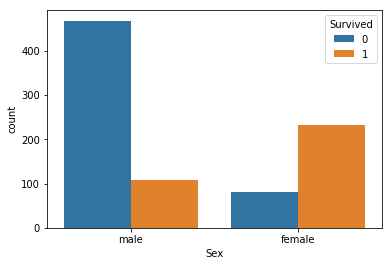

In [21]:
sns.countplot(train_data["Sex"],hue=train_data["Survived"])

###  性别明显对是否幸存有影响

# 缺失值处理

年龄缺失用均值补充，test中fare同理

In [10]:
m1=train_data[train_data["Age"].notnull()==True].Age.mean()
m2=test_data[test_data["Age"].notnull()==True].Age.mean()
train_data.Age.fillna(m1,inplace=True)
test_data.Age.fillna(m1,inplace=True)

In [12]:
m3=test_data[test_data['Fare'].notnull()==True].Fare.mean()
test_data.Fare.fillna(m3,inplace=True)

由于Embarke缺失较少，直接用S(出现最多)填充

In [13]:
train_data.Embarked.fillna('S',inplace=True)

Cabin缺失太多，直接drop掉 

In [16]:
train_data.drop("Cabin",axis=1,inplace=True)
test_data.drop("Cabin",axis=1,inplace=True)
print('over')

over


# feature_engineering

### 构建特征描述乘客是否孤身一人 

In [19]:
def if_alone(x,y):
    if x+y==0:
        return 1
    else:
        return 0
        
train_data['is_alone']=train_data.apply(lambda x: if_alone(x['SibSp'],x['Parch']),axis=1)

In [50]:
test_data['is_alone']=test_data.apply(lambda x: if_alone(x['SibSp'],x['Parch']),axis=1)

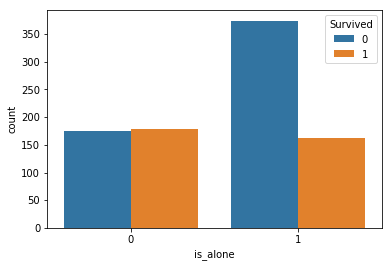

In [20]:
sns.countplot(train_data["is_alone"],hue=train_data["Survived"])

可见孤身一人的用户幸存率偏低

In [42]:
train_data['family_size']=train_data["Parch"]+train_data["SibSp"]+1

In [49]:
test_data['family_size']=test_data["Parch"]+test_data["SibSp"]+1

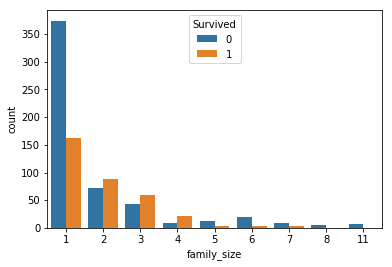

In [44]:
sns.countplot(train_data["family_size"],hue=train_data["Survived"])

### 根据称谓构建特征

In [45]:
train_data['Title'] = train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_data['Title'] = train_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
train_data['Title'] = train_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
train_data['Title'] = train_data['Title'].replace(['Lady'],'Mrs')
train_data['Title'] = train_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })

In [48]:
test_data['Title'] = test_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
test_data['Title'] = test_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
test_data['Title'] = test_data['Title'].replace(['Lady'],'Mrs')
test_data['Title'] = test_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })

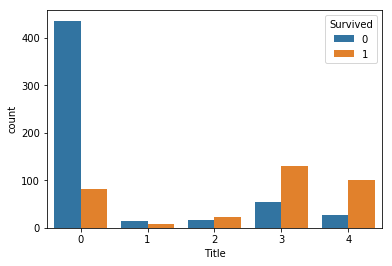

In [47]:
sns.countplot(train_data['Title'], hue=train_data['Survived'])

# 模型训练

### TPOT

In [61]:
train=train_data.drop(["Name","Survived","Ticket","PassengerId"],axis=1)
train=pd.concat([train,pd.get_dummies(train["Sex"])],axis=1)
train=pd.concat([train,pd.get_dummies(train["Embarked"])],axis=1)
train.drop(["Embarked","Sex"],axis=1,inplace=True)
train.head()

,Pclass,Age,SibSp,Parch,Fare,is_alone,family_size,Title,female,male,C,Q,S
0,3,22.0,1,0,7.2500,0,2,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,0,2,4,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,1,3,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,2,4,1,0,0,0,1
4,3,35.0,0,0,8.0500,1,1,0,0,1,0,0,1


In [66]:
train_labels=train_data["Survived"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train,train_labels,test_size=0.2)

In [69]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Generation 1 - Current best internal CV score: 0.8230832797209782
Generation 2 - Current best internal CV score: 0.8244523332027078
Generation 3 - Current best internal CV score: 0.8244523332027078
Generation 4 - Current best internal CV score: 0.8285882033259917
Generation 5 - Current best internal CV score: 0.8285882033259917

Best pipeline: DecisionTreeClassifier(SelectFwe(StandardScaler(input_matrix), alpha=0.038), criterion=entropy, max_depth=10, min_samples_leaf=8, min_samples_split=17)
0.8435754189944135


### 随机森林

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf1=RandomForestClassifier()

from sklearn.model_selection import cross_val_score

In [83]:
loss=cross_val_score(rf1,train,train_labels,cv=5,scoring="neg_log_loss")
print("loss of each fold:",-loss)
print("mean loss: ",-loss.mean())

C:\Users\wangcc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\wangcc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\wangcc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\wangcc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\wangcc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

loss of each fold: [1.87560431 2.79128995 0.89141545 1.92873338 1.3308257 ]
mean loss:  1.7635737574307355


In [87]:
New_Model = RandomForestClassifier(random_state=2,n_estimators=500,min_samples_split=30,oob_score=True)
New_Model.fit(train,train_labels)
print('New oob score :%.5f' %(New_Model.oob_score_))

New oob score :0.83165


# 提交结果

In [90]:
test=test_data.drop(["Name","Ticket","PassengerId"],axis=1)
test=pd.concat([test,pd.get_dummies(test["Sex"])],axis=1)
test=pd.concat([test,pd.get_dummies(test["Embarked"])],axis=1)
test.drop(["Embarked","Sex"],axis=1,inplace=True)
test.head()

,Pclass,Age,SibSp,Parch,Fare,Title,family_size,is_alone,female,male,C,Q,S
0,3,34.5,0,0,7.8292,0,1,1,0,1,0,1,0
1,3,47.0,1,0,7.0000,4,2,0,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,1,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,1,0,1,0,0,1
4,3,22.0,1,1,12.2875,4,3,0,1,0,0,0,1


In [91]:
New_pred = New_Model.predict(test)

submit = pd.DataFrame({"PassengerId": test_data['PassengerId'],
                      "Survived":New_pred.astype(int)})
submit.to_csv("titanic_submission.csv",index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
